In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import joblib

import matplotlib.pyplot as plt

In [2]:
def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, -100:], indices[:, -100:]


def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, :100], indices[:, :100]


def calculate_distance(x, close_fn, far_fn):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch_size = 2048
    x_device = x.to(device)
    
    num_iter = x.shape[0] // batch_size + 1
    anchor_idx_list, close_idx_list, far_idx_list = list(), list(), list()
    close_distance_list, far_distance_list = list(), list()
    for i in tqdm(torch.arange(num_iter), desc='create triplets'):
        batch_x = x[i * batch_size: (i + 1) * batch_size, :].to(device)

        dist = torch.cdist(x1=batch_x, x2=x_device, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        sorted_dist, indices = sorted_dist, indices
        anchor_idx = torch.arange(i * batch_size, i * batch_size + batch_x.shape[0])  # (n,)
        # assert torch.equal(anchor_idx, indices[:, 0].cpu())
        # the 0-th column is the distance to oneself
        close_distance, close_idx = close_fn(sorted_dist, indices)  # (n,)
        far_distance, far_idx = far_fn(sorted_dist, indices)  # (n, r)
        anchor_idx_list.append(anchor_idx.cpu())
        close_idx_list.append(close_idx.cpu())
        far_idx_list.append(far_idx.cpu())
        close_distance_list.append(close_distance.cpu())
        far_distance_list.append(far_distance.cpu())
    anchor_idx_list = torch.cat(anchor_idx_list, dim=0)
    close_idx_list = torch.cat(close_idx_list, dim=0)
    far_idx_list = torch.cat(far_idx_list, dim=0)
    close_distance_list = torch.cat(close_distance_list, dim=0)
    far_distance_list = torch.cat(far_distance_list, dim=0)
    return anchor_idx_list, close_idx_list, far_idx_list, close_distance_list, far_distance_list

In [3]:
mode = 'train'
data = torch.from_numpy(pd.read_csv(f'../data/{mode}.csv', header=None).to_numpy())

anchor_idx, close_idx, far_idx, close_distance, far_distance = calculate_distance(data, close_func, far_func)

In [4]:
torch.save({
    'data': data,
    'anchor_idx': anchor_idx, 
    'close_idx': close_idx, 
    'far_idx': far_idx, 
    'close_distance': close_distance, 
    'far_distance': far_distance},
    f'../data/{mode}.pt'
)

In [5]:
close_distance.mean(dim=0)

tensor([9.4498e-06, 2.7445e+01, 2.7784e+01, 2.7964e+01, 2.8089e+01, 2.8184e+01,
        2.8262e+01, 2.8328e+01, 2.8385e+01, 2.8436e+01, 2.8481e+01, 2.8523e+01,
        2.8560e+01, 2.8595e+01, 2.8628e+01, 2.8658e+01, 2.8687e+01, 2.8714e+01,
        2.8739e+01, 2.8763e+01, 2.8787e+01, 2.8809e+01, 2.8830e+01, 2.8850e+01,
        2.8869e+01, 2.8888e+01, 2.8906e+01, 2.8924e+01, 2.8940e+01, 2.8957e+01,
        2.8972e+01, 2.8988e+01, 2.9003e+01, 2.9017e+01, 2.9031e+01, 2.9045e+01,
        2.9058e+01, 2.9071e+01, 2.9084e+01, 2.9096e+01, 2.9108e+01, 2.9120e+01,
        2.9132e+01, 2.9143e+01, 2.9154e+01, 2.9165e+01, 2.9176e+01, 2.9186e+01,
        2.9197e+01, 2.9207e+01, 2.9217e+01, 2.9226e+01, 2.9236e+01, 2.9245e+01,
        2.9255e+01, 2.9264e+01, 2.9273e+01, 2.9281e+01, 2.9290e+01, 2.9299e+01,
        2.9307e+01, 2.9315e+01, 2.9323e+01, 2.9331e+01, 2.9339e+01, 2.9347e+01,
        2.9355e+01, 2.9363e+01, 2.9370e+01, 2.9377e+01, 2.9385e+01, 2.9392e+01,
        2.9399e+01, 2.9406e+01, 2.9413e+

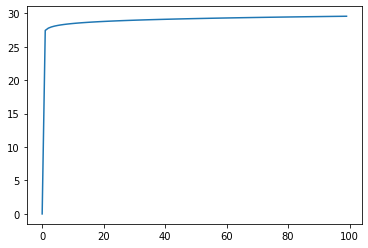

In [6]:
plt.plot(close_distance.mean(dim=0))

In [7]:
far_distance.mean(dim=0)

tensor([614.0783, 614.0838, 614.0893, 614.0948, 614.1004, 614.1061, 614.1118,
        614.1175, 614.1234, 614.1292, 614.1352, 614.1412, 614.1473, 614.1534,
        614.1597, 614.1660, 614.1724, 614.1789, 614.1855, 614.1923, 614.1991,
        614.2060, 614.2130, 614.2201, 614.2273, 614.2347, 614.2422, 614.2500,
        614.2579, 614.2661, 614.2745, 614.2832, 614.2921, 614.3013, 614.3108,
        614.3206, 614.3301, 614.3395, 614.3489, 614.3582, 614.3677, 614.3774,
        614.3872, 614.3969, 614.4066, 614.4163, 614.4259, 614.4355, 614.4451,
        614.4549, 614.4647, 614.4748, 614.4850, 614.4956, 614.5065, 614.5177,
        614.5292, 614.5410, 614.5531, 614.5656, 614.5783, 614.5912, 614.6047,
        614.6188, 614.6337, 614.6491, 614.6651, 614.6810, 614.6965, 614.7121,
        614.7275, 614.7429, 614.7586, 614.7751, 614.7927, 614.8115, 614.8314,
        614.8531, 614.8771, 614.9020, 614.9272, 614.9530, 614.9786, 615.0087,
        615.0414, 615.0708, 615.1017, 615.1374, 615.1794, 615.23

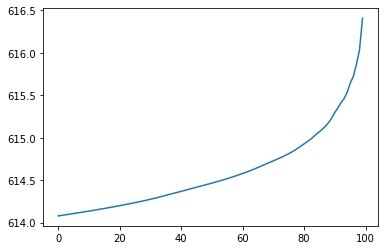

In [8]:
plt.plot(far_distance.mean(dim=0))

In [9]:
close_distance.std(dim=0)

tensor([1.1456e-05, 6.1155e+00, 6.1831e+00, 6.2207e+00, 6.2468e+00, 6.2669e+00,
        6.2835e+00, 6.2976e+00, 6.3098e+00, 6.3205e+00, 6.3302e+00, 6.3390e+00,
        6.3473e+00, 6.3549e+00, 6.3619e+00, 6.3686e+00, 6.3748e+00, 6.3808e+00,
        6.3864e+00, 6.3917e+00, 6.3968e+00, 6.4017e+00, 6.4063e+00, 6.4107e+00,
        6.4148e+00, 6.4189e+00, 6.4229e+00, 6.4266e+00, 6.4303e+00, 6.4338e+00,
        6.4372e+00, 6.4405e+00, 6.4437e+00, 6.4469e+00, 6.4500e+00, 6.4529e+00,
        6.4559e+00, 6.4587e+00, 6.4614e+00, 6.4641e+00, 6.4667e+00, 6.4692e+00,
        6.4717e+00, 6.4741e+00, 6.4766e+00, 6.4791e+00, 6.4814e+00, 6.4837e+00,
        6.4860e+00, 6.4883e+00, 6.4905e+00, 6.4926e+00, 6.4946e+00, 6.4967e+00,
        6.4988e+00, 6.5007e+00, 6.5027e+00, 6.5046e+00, 6.5065e+00, 6.5084e+00,
        6.5102e+00, 6.5120e+00, 6.5137e+00, 6.5155e+00, 6.5172e+00, 6.5189e+00,
        6.5206e+00, 6.5222e+00, 6.5239e+00, 6.5255e+00, 6.5271e+00, 6.5286e+00,
        6.5301e+00, 6.5317e+00, 6.5332e+

In [10]:
far_distance.std(dim=0)

tensor([14.8873, 14.8868, 14.8863, 14.8857, 14.8852, 14.8846, 14.8840, 14.8834,
        14.8827, 14.8820, 14.8812, 14.8805, 14.8797, 14.8789, 14.8781, 14.8773,
        14.8764, 14.8755, 14.8746, 14.8736, 14.8727, 14.8717, 14.8707, 14.8698,
        14.8688, 14.8678, 14.8668, 14.8659, 14.8651, 14.8643, 14.8637, 14.8632,
        14.8629, 14.8628, 14.8631, 14.8634, 14.8637, 14.8640, 14.8643, 14.8648,
        14.8654, 14.8664, 14.8674, 14.8685, 14.8692, 14.8698, 14.8701, 14.8702,
        14.8701, 14.8698, 14.8693, 14.8686, 14.8678, 14.8667, 14.8656, 14.8642,
        14.8628, 14.8613, 14.8599, 14.8586, 14.8573, 14.8560, 14.8545, 14.8530,
        14.8515, 14.8497, 14.8470, 14.8438, 14.8408, 14.8379, 14.8352, 14.8330,
        14.8310, 14.8293, 14.8277, 14.8262, 14.8248, 14.8238, 14.8223, 14.8211,
        14.8206, 14.8212, 14.8200, 14.8203, 14.8244, 14.8216, 14.8163, 14.8109,
        14.8074, 14.8076, 14.8020, 14.7893, 14.7731, 14.7592, 14.7423, 14.7745,
        14.7492, 14.6818, 14.6895, 14.78

In [7]:
# check dataset
from src.models.siamese_triplet.datasets import SiameseSynthesis
from pathlib import Path
import torch

In [2]:

siamese_test_dataset = SiameseSynthesis(Path('../data/dev.pt'))

In [3]:
siamese_test_dataset[0]

((tensor(0), tensor(0)), 1)

In [4]:
siamese_test_dataset[1]

((tensor(0), tensor(202)), 1)

In [15]:
siamese_test_dataset[201]

((tensor(1), tensor(598)), 1)

In [8]:
d = torch.load('../data/dev.pt')

In [9]:
d['close_idx']

tensor([[  0, 202, 299,  ..., 271, 935, 449],
        [  1, 598, 599,  ..., 464, 832, 273],
        [  2,  55, 140,  ..., 124, 556, 808],
        ...,
        [997,  58,  97,  ..., 948, 556, 756],
        [998, 281, 986,  ..., 132, 198, 698],
        [999, 986, 501,  ..., 274, 936, 442]])